# Image Based Geolocation using Transfer Learning and CNNs


## Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import imageio
from PIL import Image
import numpy as np
import tensorflow
import tensorflow.keras as keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation
from keras.models import Model, Sequential, load_model
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from keras.layers import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

## Image Data Generator

In [ ]:
batchSize = 20
imgHeight = 224
imgWidth = 224
numClasses = 10

In [ ]:
dataPath = "/content/drive/MyDrive/Geolocation_Data/"
mySeed = 5737213
dataGenObject = ImageDataGenerator(rescale=1.0 / 255,
                                   validation_split=0.3)
trainGenerator = dataGenObject.flow_from_directory(dataPath,
                                                   classes=['london streets']
,
                                                   class_mode='sparse',
                                                   seed=mySeed,
                                                   target_size=(imgHeight, imgWidth),
                                                   batch_size=batchSize,
                                                   subset="training")
validGenerator = dataGenObject.flow_from_directory(dataPath,
                                                   class_mode='sparse',
                                                   seed=mySeed,
                                                   target_size=(imgHeight, imgWidth),
                                                   batch_size=batchSize,
                                                   subset="validation")

Found 2831 images belonging to 1 classes.
Found 12064 images belonging to 10 classes.


### Code to view Images

In [ ]:
x, y = next(trainGenerator)
print(x.shape)
print(y.shape)

(20, 224, 224, 3)
(20,)


In [ ]:
print(y)
y_list =[]
for i in y:
  y_list.append(['London']
[int(i)])
print(y_list)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London', 'London']


In [ ]:
predictions = model.predict(x)
predictions = [np.argmax(p) for p in predictions]
print(predictions)
predict_list=[]
for i in predictions:
  predict_list.append(['Amsterdam', 'Bangkok', 'Barcelona', 'London', 'Los Angeles', 'Mumbai', 'New York', 'Paris', 'Tokyo', 'Venice'][int(i)])
print(predict_list)

[8, 3, 8, 4, 0, 2, 3, 1, 8, 3, 8, 2, 3, 8, 0, 7, 3, 8, 4, 2]
['Tokyo', 'London', 'Tokyo', 'Los Angeles', 'Amsterdam', 'Barcelona', 'London', 'Bangkok', 'Tokyo', 'London', 'Tokyo', 'Barcelona', 'London', 'Tokyo', 'Amsterdam', 'Paris', 'London', 'Tokyo', 'Los Angeles', 'Barcelona']


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_grid(image_list,nrows,ncols,label_list=None,pred_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title("Actual: " + label_list[i] + "  Predicted: " + pred_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

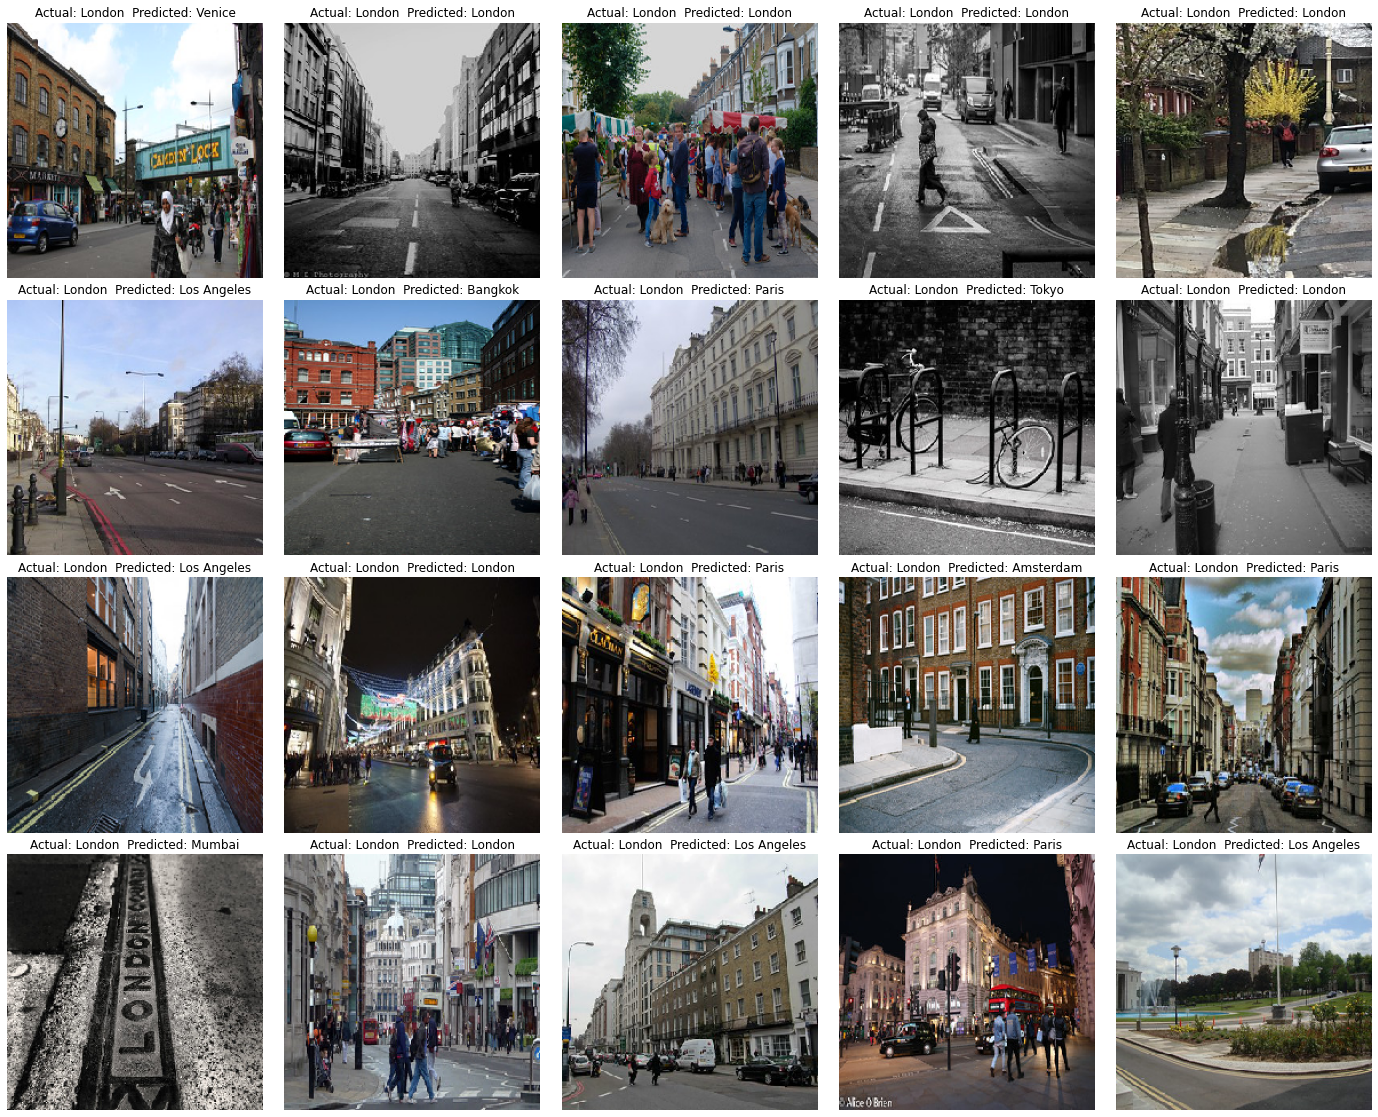

In [ ]:
show_grid(x,4,5,label_list=y_list,pred_list=predict_list,show_labels=True,figsize=(30,20))


## Using pretrained model

In [ ]:
from tensorflow.keras.applications import vgg16
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_conv.layers[:]:
    layer.trainable = False

for layer in vgg_conv.layers:
  print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f5d460fcd50> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321ad710> False
<keras.layers.convolutional.Conv2D object at 0x7f5d46171c90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5d460cbd10> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321b8410> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321bcf50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5d321b4f50> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321c27d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321cc0d0> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321bfa90> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5db0031550> False
<keras.layers.convolutional.Conv2D object at 0x7f5d32158ed0> False
<keras.layers.convolutional.Conv2D object at 0x7f5d3215db90> False
<keras.layers.convolutional.Conv2D object at 0x7f5d321cf810> False
<keras.layers.pooling.MaxPooling2D object at 0x7f5d32168550>

## Adding layers to model and compiling

In [ ]:
model = Sequential()
model.add(vgg_conv)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 40,416,074
Trainable params: 25,701,386
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

##Creating callback function to prevent overfitting and training the model

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 7,
                                        restore_best_weights = True)


In [ ]:
history = model.fit(trainGenerator,
                    validation_data=validGenerator,
                    batch_size=batchSize,
                    workers=8,
                    epochs=25,
                    callbacks =[earlystopping]
                    )

Epoch 1/25
1878/1878 [==============================] - 478s 254ms/step - loss: 2.0584 - accuracy: 0.3092 - val_loss: 1.8466 - val_accuracy: 0.3543
Epoch 2/25
1878/1878 [==============================] - 474s 252ms/step - loss: 1.7730 - accuracy: 0.3753 - val_loss: 1.7659 - val_accuracy: 0.3886
Epoch 3/25
1878/1878 [==============================] - 481s 256ms/step - loss: 1.7261 - accuracy: 0.3903 - val_loss: 1.6919 - val_accuracy: 0.4181
Epoch 4/25
1878/1878 [==============================] - 472s 251ms/step - loss: 1.6776 - accuracy: 0.4121 - val_loss: 1.7472 - val_accuracy: 0.4096
Epoch 5/25
1878/1878 [==============================] - 469s 249ms/step - loss: 1.6644 - accuracy: 0.4198 - val_loss: 1.6696 - val_accuracy: 0.4392
Epoch 6/25
1878/1878 [==============================] - 475s 252ms/step - loss: 1.6320 - accuracy: 0.4296 - val_loss: 1.6512 - val_accuracy: 0.4424
Epoch 7/25
 724/1878 [==========>...................] - ETA: 3:26 - loss: 1.6165 - accuracy: 0.4364

In [ ]:
print(history.history.keys())
model.save("newgeomodel")

## Plotting accuracy and loss

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Loading trained model

In [ ]:
model = load_model('/content/drive/MyDrive/geomodel')

In [ ]:
model.load_weights('/content/drive/MyDrive/geomodel')

## Visualizing the model

In [ ]:
!pip install visualkeras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 17.6 MB/s 


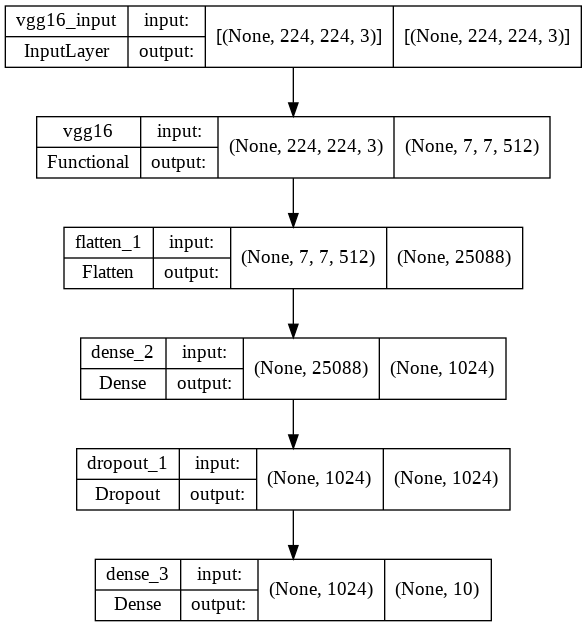

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

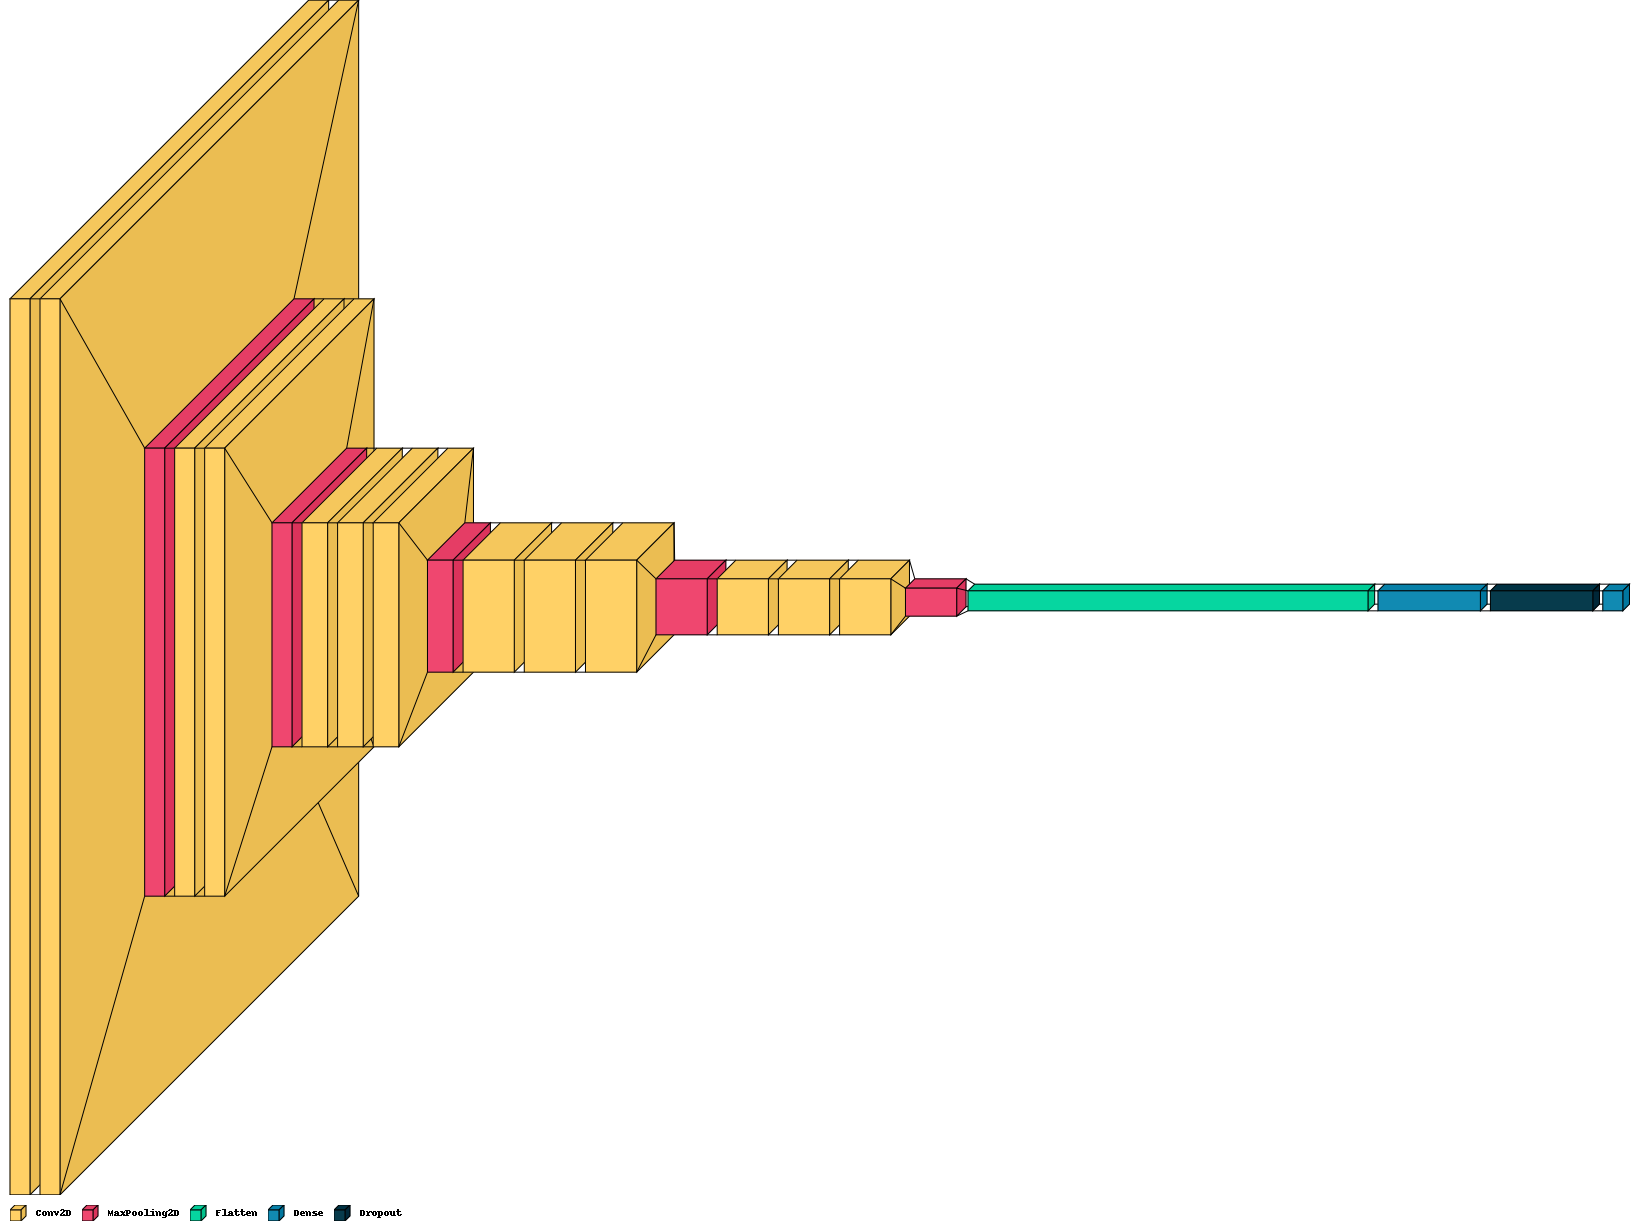

In [ ]:
import visualkeras

from PIL import ImageFont

font = ImageFont.load_default()
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model,legend=True, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

## Determining accuracy and Confusion Matrix

In [ ]:
print(sorted(os.listdir(dataPath)))

['amsterdam streets', 'bangkok streets', 'barcelona streets', 'london streets', 'los angeles streets', 'mumbai streets', 'new york streets', 'paris streets', 'tokyo streets', 'venice streets']


In [ ]:
cities = sorted(os.listdir(dataPath))
final_pred = []
count = 0
for city in cities:
  image_list = os.listdir(dataPath + "/" + city)[:500]
  predictions = []
  print("loading " + city)
  for im_name in image_list:
    if im_name.endswith(".jpg"):
      img = Image.open(dataPath + "/" + city + "/" + im_name)
      img = img.resize((224, 224))
      img_arr = np.array(img)
      img_arr = img_arr/255.0
      if img_arr.shape == (224, 224, 3):
        print(count)
        count += 1
        predictions.append(model.predict(np.array([img_arr])))
  print("predicting " + city)
  # predictions = model.predict(np.array(predictions))
  predictions = [np.argmax(p) for p in predictions]
  predictions = np.array(predictions)
  final_pred.append(predictions)
final_pred = np.array(final_pred)
np.save("final_predictions", final_pred)

In [ ]:
preds = np.load('/content/interim_pred.npy', allow_pickle=True)

In [ ]:
for city in preds:
  print(np.unique(city, return_counts=True))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([306,   2,  34,  56,  35,   5,   1,   6,  46,   9]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([  3, 281,  14,   6,  83,  49,   1,   1,  58,   2]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 10,   4, 298,  14,  82,  16,   1,  47,  12,   9]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 20,   9,  38, 171, 103,  11,   5,  69,  64,   6]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([  4,  22,  11,  13, 360,  20,  10,   8,  46,   1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([  6,  52,  43,   3, 137, 244,   4,   7,   3]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([  2,   2,   9,   3,  29,   1, 427,   3,  21,   1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 11,   8,  57,  80,  84,  22,   1, 207,  18,  10]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([  4,  37,  21,  17,  73,  12,   1,   5, 329,   1]))
(array([0, 2, 3, 4, 5, 7, 8, 9]), array([  8,  51,   4,  15,   1,   7,   2, 408]))


In [ ]:
from sklearn import metrics
i = 0
right = []
for city in preds:
  actual = np.full_like(city, i)
  right.append(actual)
  print(len(city), len(actual))
  i += 1

preds = np.concatenate(preds)
right = np.concatenate(right)

confusion = metrics.confusion_matrix(preds, right,
                              #  labels=["Amsterdam", "Bangkok", "Barcelona", 'London', 'Los Angeles', 'Mumbai', 'New York', 'Paris', 'Tokyo', 'Venice']
                               )
print(confusion)

500 500
498 498
493 493
496 496
495 495
499 499
498 498
498 498
500 500
496 496
[[306   3  10  20   4   6   2  11   4   8]
 [  2 281   4   9  22  52   2   8  37   0]
 [ 34  14 298  38  11  43   9  57  21  51]
 [ 56   6  14 171  13   3   3  80  17   4]
 [ 35  83  82 103 360 137  29  84  73  15]
 [  5  49  16  11  20 244   1  22  12   1]
 [  1   1   1   5  10   4 427   1   1   0]
 [  6   1  47  69   8   7   3 207   5   7]
 [ 46  58  12  64  46   3  21  18 329   2]
 [  9   2   9   6   1   0   1  10   1 408]]


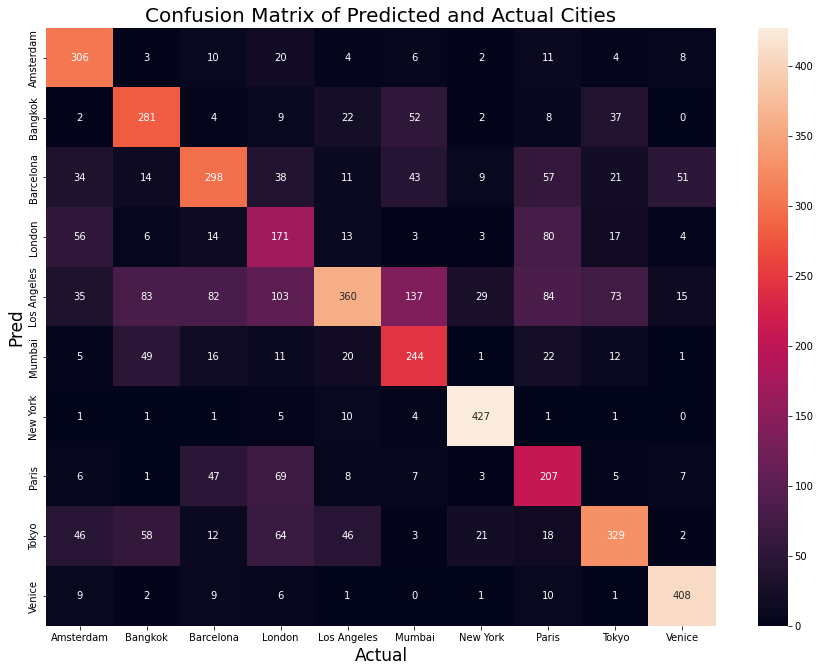

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(11)
df_cm = pd.DataFrame(confusion, index = ["Amsterdam", "Bangkok", "Barcelona", 'London', 'Los Angeles', 'Mumbai', 'New York', 'Paris', 'Tokyo', 'Venice'],
                  columns = ["Amsterdam", "Bangkok", "Barcelona", 'London', 'Los Angeles', 'Mumbai', 'New York', 'Paris', 'Tokyo', 'Venice'])
sn.heatmap(df_cm, annot=True, fmt='g')

plt.title('Confusion Matrix of Predicted and Actual Cities', fontsize = 20) # title with fontsize 20
plt.xlabel('Actual', fontsize = 17) # x-axis label with fontsize 15
plt.ylabel('Pred', fontsize = 17) # y-axis label with fontsize 15
plt.show()
